In [1]:
import pycap
print pycap.__file__
print pycap.__git_branch__,pycap.__git_commit_hash__
from pycap import initialize_data,report_data,plot_data,MultiStage
import numpy
from matplotlib import pyplot
%matplotlib inline

/Users/qdi/Projects/cap/clang/install/cap/python/pycap/__init__.pyc
master de9ee2e36db8132613be47d6852b066959167e62


In [2]:
input_database=pycap.PropertyTree()
input_database.parse_xml('../cap/test/data/input_multi_stage')

#device=pycap.EnergyStorageDevice(input_database.get_child('device'))
device=pycap.EnergyStorageDevice(input_database)

data=initialize_data()
experiment=MultiStage(input_database.get_child('operating_conditions'))
experiment.run(device,data)


122
153
197
297
341
371
415
515


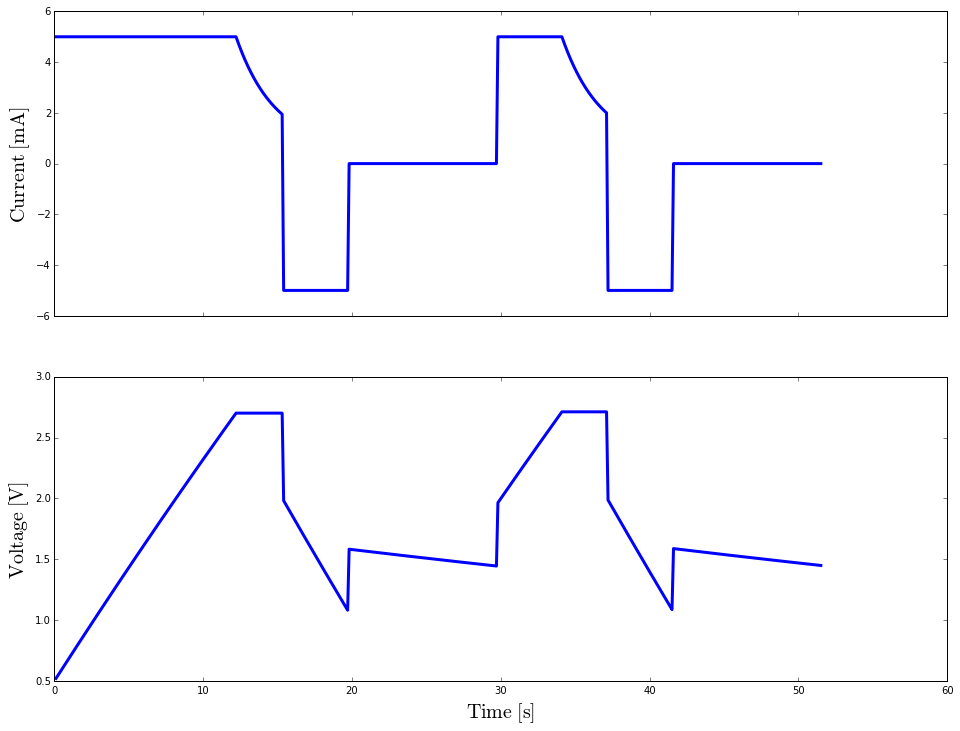

In [4]:
plot_data(data)